In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pystencils.runhelper.db import removeConstantColumns
from pystencils.runhelper import Database

%matplotlib inline

db = Database("./shear_wave_db")
db.pandasColumnsToIgnore = ['changedParams.', 'params.optimizationParams.',
                            'env.cpuCompilerConfig', 'env.timestamp']

In [2]:
def cleanupDb():
    allData = db.filter({})
    for d in allData:
        params = d.params
        if 'optimizationParams' not in params:
            params['optimizationParams'] = {}
        newParams, newOptParams = updateWithDefaultParameters(params, params['optimizationParams'], False)
        d.params = newParams
        d.params['optimizationParams'] = newOptParams
        if d.params['stencil'] == 'D2Q9':
            d.params['stencil'] = 'D3Q27'
        d.save()


In [3]:
def cleanupMethodColumn(df):
    df = df.copy()
    df.insert(0, 'tmp', np.nan)
    df.loc[(df.method=='mrt3') & (df.cumulant==True), 'tmp'] = 'cumulant'        
    df.loc[(df.method=='mrt3') & (df.cumulant==False), 'tmp'] = 'mrt'
    df.loc[(df.method=='trt-kbc-n4') & (df.cumulant==False) & (df.entropic==True), 'tmp'] = 'entropic'
    df.loc[(df.method=='trt-kbc-n4') & (df.cumulant==True)  & (df.entropic==True), 'tmp'] = 'entropic-cumulant'

    df.loc[df.method=='srt', 'tmp'] = 'srt'
    
    rr = df['relaxationRates'].apply(pd.Series)
    df.loc[(df.method=='trt') & (rr[1] == 1), 'tmp'] = 'trt_one'
    df.loc[(df.method=='trt') & (rr[1] == "(-2*omega + 4)/(-omega/4 + 2)"), 'tmp'] = 'trt_magic'
    
    del df['method']
    del df['relaxationRates']
    del df['force']
    del df['entropic']
    if 'cumulant' in df.columns:
        del df['cumulant']
    df = df.rename(columns = {'tmp' :'method'})
    
    categories = ['srt', 'trt_one', 'trt_magic', 'mrt', 'cumulant', 'entropic', 'entropic-cumulant']
    df = df.assign(method=lambda x: pd.Categorical(x['method'], categories=categories, ordered=True))
    df, constantCols = removeConstantColumns(df)
    print(constantCols)
    return df

## Checking results given in Fig2

In [6]:
params = {'useContinuousMaxwellianEquilibrium': False,
          'compressible': True,
          'forceModel': 'silva',
          'stencil': "D3Q27",
          'equilibriumAccuracyOrder': 2,
          'ySize': 1,
          'cumulant': False,
          'en'
         }


### Reproducing results from Geiers Paper

In [5]:
params = {'useContinuousMaxwellianEquilibrium': True,
          'compressible': True,
          'stencil': "D3Q27",
          'equilibriumAccuracyOrder': 3,
          'ySize': 1,
         }

df = db.toPandas(params, dropConstantColumns=False)
df = cleanupMethodColumn(df)
del df['hostname']
del df['mlups']
df = df.set_index(['nu', 'method', 'L']).sort_index()
df = df.sort_index(level=[0,1,2])
df = df.assign(phaseError = lambda x: np.abs(x.phaseError) )
#df

L_0                                      32
compressible                           True
entropicNewtonIterations               None
equilibriumAccuracyOrder                  3
forceModel                             none
initialVelocity                        None
omegaOutputField                       None
periodicityInKernel                    True
stencil                               D3Q27
u_0                                   0.096
useContinuousMaxwellianEquilibrium     True
v_0                                     0.1
ySize                                     1
Name: 00303806ec3d4733a72a61334f172bb8, dtype: object


### 3rd Order Equilibrium

In [5]:
df.loc[(1e-3, 'cumulant')]

,phaseError,viscosityError
L,,
32,6.930304e-07,0.006271
64,1.090044e-08,0.001237
128,1.703872e-10,0.000292
256,2.468612e-12,0.000072


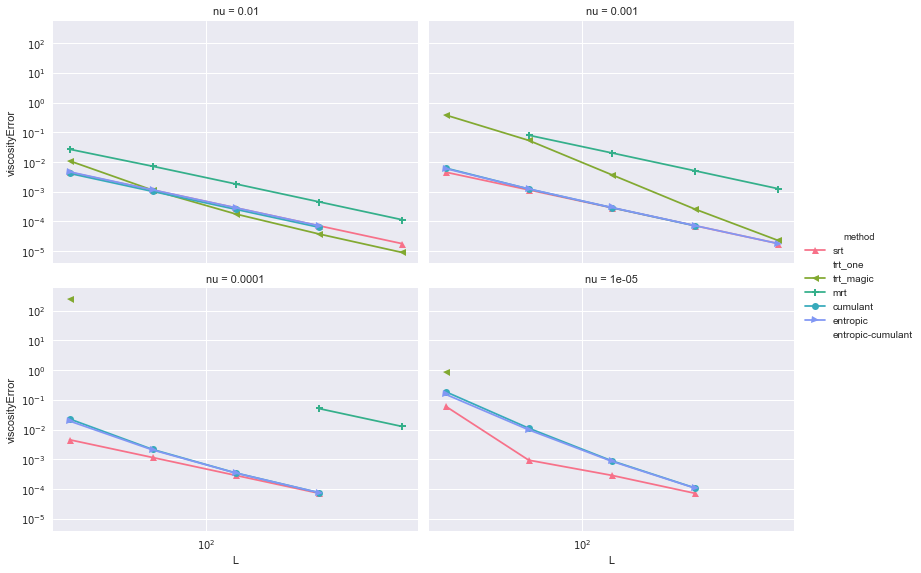

In [6]:
pltDf = df.reset_index()
g = sns.FacetGrid(pltDf, col="nu", hue="method", 
                  col_wrap=2, col_order=pltDf['nu'].unique()[::-1],
                  size=4, aspect=1.4, legend_out=True, hue_kws=dict(marker=["^", "v", '<', 'P', 'o', '>']))
g.map(plt.plot, "L", 'viscosityError').add_legend()
g.set(xscale="log", yscale="log");

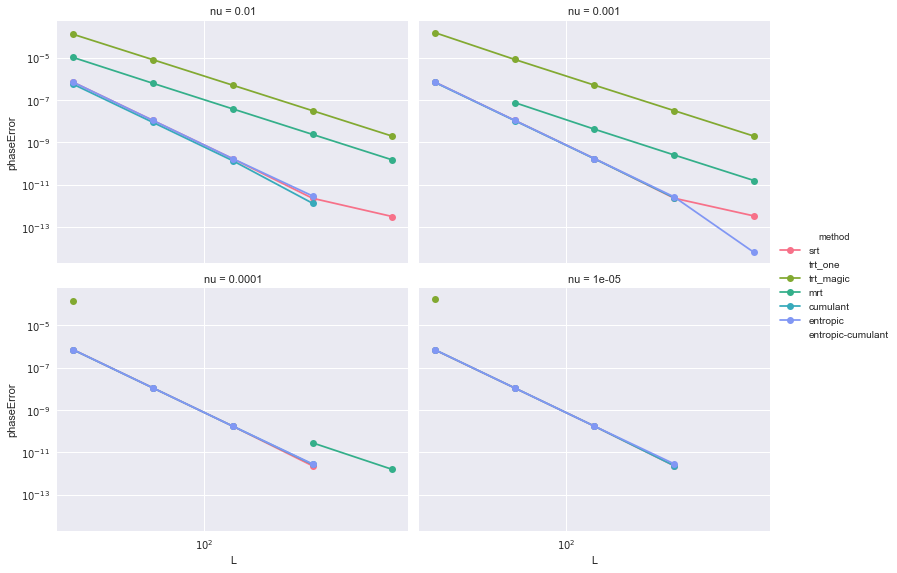

In [7]:
pltDf = df.reset_index()
g = sns.FacetGrid(pltDf, col="nu", hue="method", 
                  col_wrap=2, col_order=pltDf['nu'].unique()[::-1],
                  size=4, aspect=1.4, legend_out=True)
g.map(plt.plot, "L", 'phaseError', marker='o').add_legend()
g.set(xscale="log", yscale="log");

Plotting only a single graph:

method,srt,trt_magic,mrt,cumulant,entropic
L,,,,,
32,7.132551e-07,0.000147,NaN,7.062766e-07,7.128203e-07
64,1.114986e-08,NaN,NaN,1.110863e-08,1.114825e-08
128,1.738588e-10,NaN,NaN,1.738305e-10,1.741583e-10
256,2.333423e-12,NaN,2.843368e-11,2.733735e-12,2.871477e-12
512,NaN,NaN,1.574884e-12,NaN,NaN


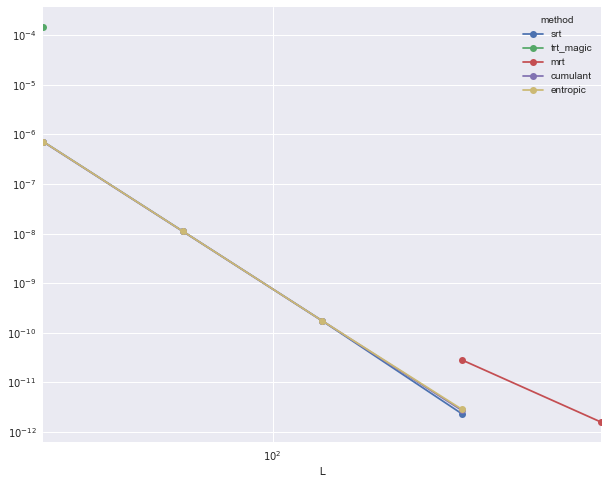

In [8]:
selectViscosity = 1e-4
data = df.loc[(selectViscosity)]['phaseError'].unstack(level=0)
data.plot(logx=True, logy=True, marker='o', figsize=(10,8))
data

## Reduced stencils

In [12]:
params = {'method': 'srt',
          'compressible': True,
          'ySize': 1,}

df = db.toPandas(params, dropConstantColumns=False)
df = cleanupMethodColumn(df)
del df['hostname']
del df['mlups']
df = df.set_index(['stencil', 'nu', 'equilibriumAccuracyOrder', 'L']).sort_index()
df = df.sort_index(level=[0,1,2])
df = df.assign(phaseError = lambda x: np.abs(x.phaseError) )
df.loc[('D3Q19',1e-5)]

method                        srt
L_0                            32
compressible                 True
entropicNewtonIterations     None
forceModel                   none
initialVelocity              None
omegaOutputField             None
periodicityInKernel          True
u_0                         0.096
v_0                           0.1
ySize                           1
Name: 861493f9c4f04ccda2e05b13ec77d229, dtype: object


useContinuousMaxwellianEquilibrium    phaseError  \
equilibriumAccuracyOrder L                                                      
1                        32                               False  1.554623e-19   
                         32                                True  2.487397e-19   
                         64                                True  2.254204e-19   
                         64                               False  2.254204e-19   
                         128                              False  1.787817e-19   
                         128                               True  1.787817e-19   
                         256                               True  6.801476e-21   
                         256                              False  2.720591e-20   
2                        32                                True  2.592976e-05   
                         32                               False           NaN   
                         64                                True  1.666409e-06   
                         64                               False           NaN   
                         128                              False           NaN   
                         128                               True  1.048924e-07   
                         256                               True  6.568541e-09   
                         256                              False  3.018647e-06   
3                        32                                True  2.759086e-05   
                         32                               False           NaN   
                         64                                True  1.692622e-06   
                         64                               False           NaN   
                         128                              False           NaN   
                         128                               True  1.053012e-07   
                         256                               True  6.574926e-09   
                         256                              False  3.081155e-06   

                              viscosityError  
equilibriumAccuracyOrder L                    
1                        32         0.000813  
                         32         0.000813  
                         64         0.000163  
                         64         0.000163  
                         128        0.000043  
                         128        0.000043  
                         256        0.000011  
                         256        0.000011  
2                        32         0.055683  
                         32              NaN  
                         64         0.004814  
                         64              NaN  
                         128             NaN  
                         128        0.001153  
                         256        0.000288  
                         256      327.819809  
3                        32         0.100255  
                         32              NaN  
                         64         0.000238  
                         64              NaN  
                         128             NaN  
                         128        0.000043  
                         256        0.000011  
                         256      295.992995

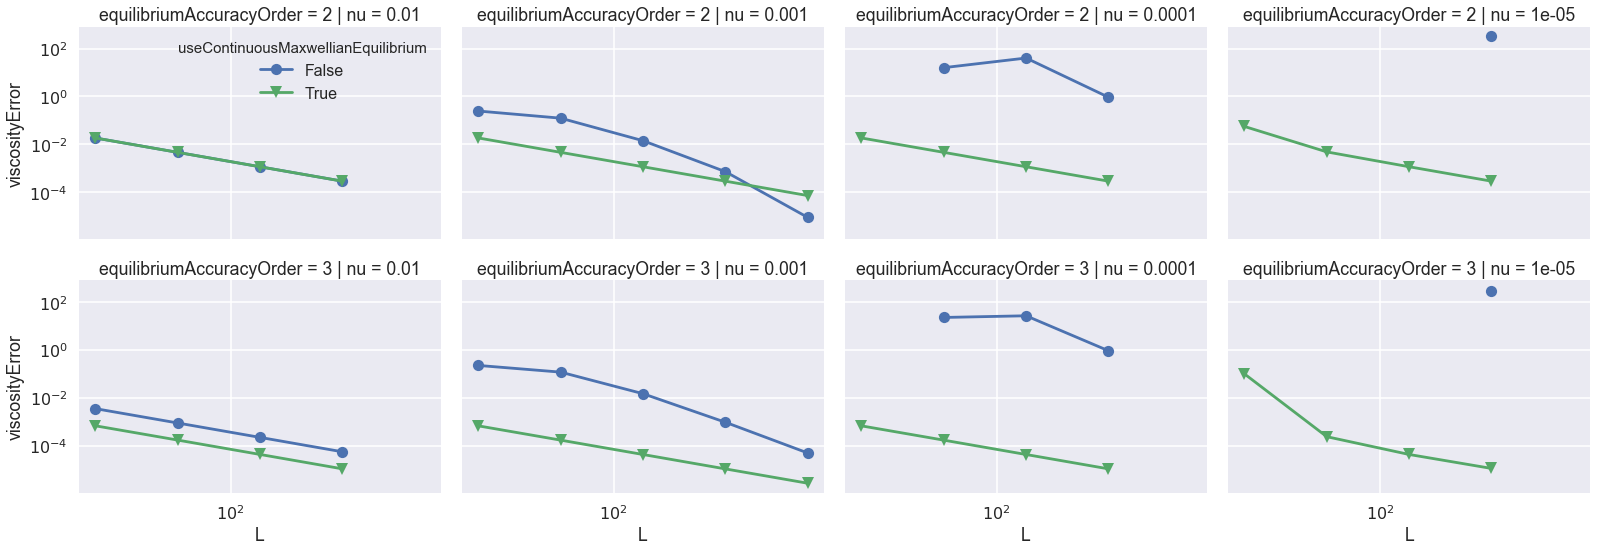

In [24]:
sns.set_context("poster")
pltDf = df.loc['D3Q19'].reset_index()

pltDf = pltDf[pltDf['equilibriumAccuracyOrder'] > 1]
g = sns.FacetGrid(pltDf, col="nu", row='equilibriumAccuracyOrder',
                  hue="useContinuousMaxwellianEquilibrium",  hue_kws=dict(marker=["o", "v"]),
                  col_order=pltDf['nu'].unique()[::-1],
                  size=4, aspect=1.4,  legend_out=False)
g.map(plt.plot, "L", 'viscosityError', marker='o').add_legend()
g.set(xscale="log", yscale="log");

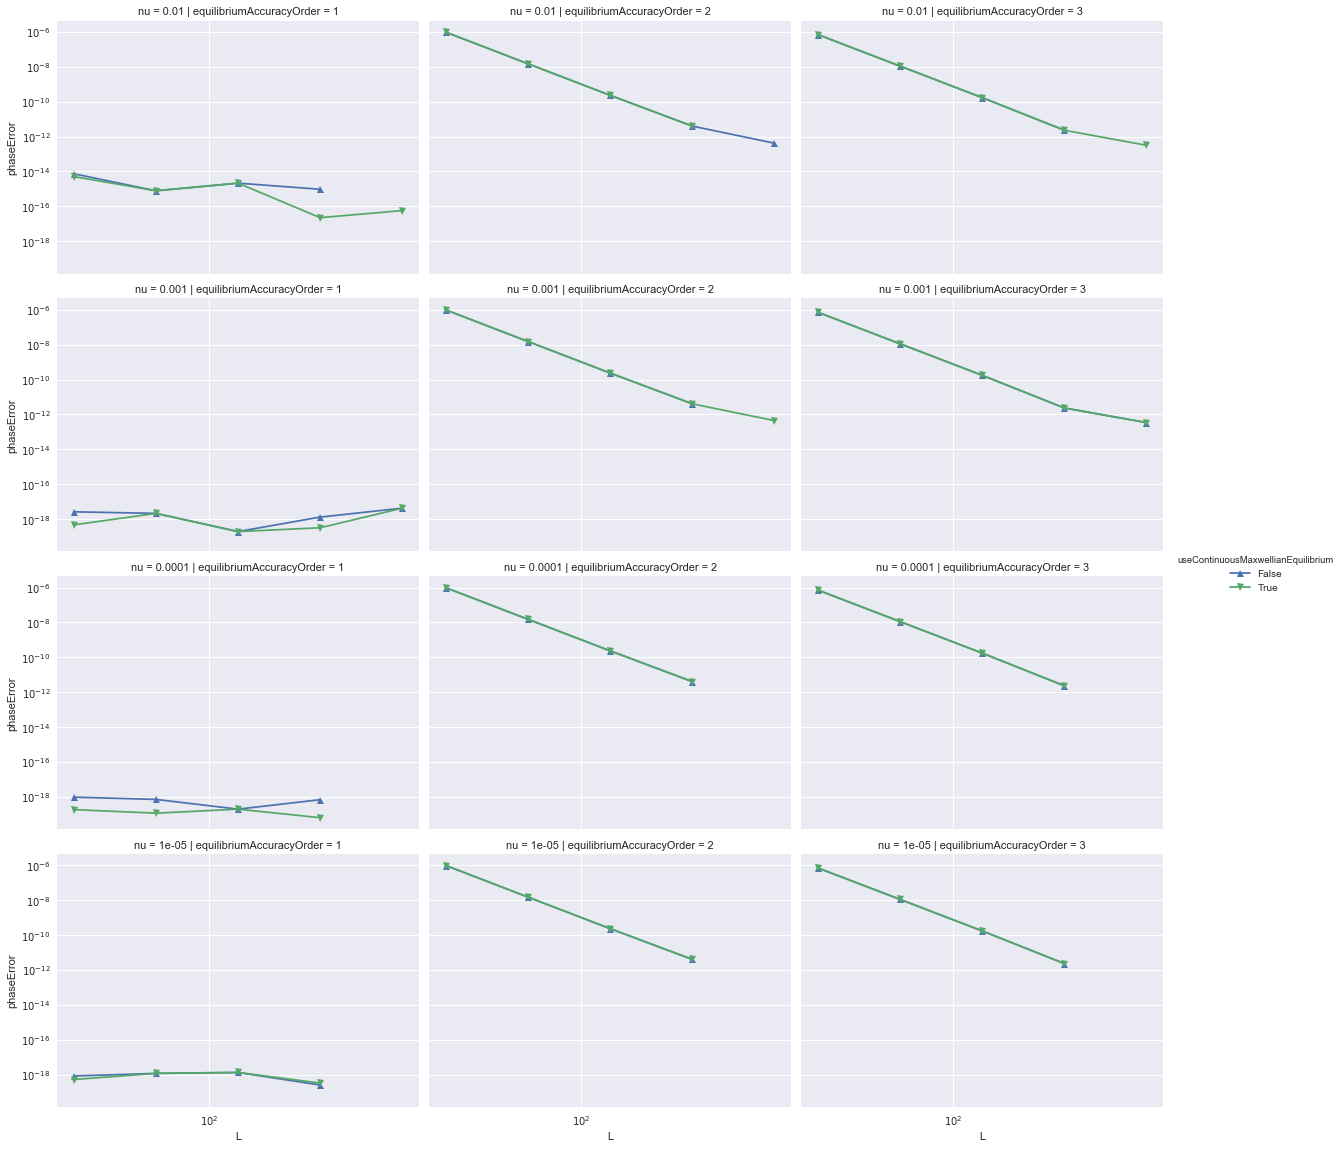

In [11]:
pltDf = df.loc['D3Q27'].reset_index()

g = sns.FacetGrid(pltDf, row="nu", col='equilibriumAccuracyOrder',
                  hue="useContinuousMaxwellianEquilibrium",  hue_kws=dict(marker=["^", "v"]),
                  row_order=pltDf['nu'].unique()[::-1],
                  size=4, aspect=1.4, legend_out=True)


#g = sns.FacetGrid(pltDf, col="nu", hue="useContinuousMaxwellianEquilibrium", 
#                  col_wrap=2, col_order=pltDf['nu'].unique()[::-1],
#                  size=4, aspect=1.4, legend_out=True)
g.map(plt.plot, "L", 'phaseError', marker='o').add_legend()
g.set(xscale="log", yscale="log");